In [22]:
import os
import sys
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from data.load_data import download_creditcard_data, load_creditcard_df

# Project step 4: XGBoost on credit card fraud detection

In this notebook we use XGBoost, a gradient boosting algorithm that builds trees sequentially. Each new tree tries to fix the mistakes of the previous ones. Its known for being fast and accurate on tabular data like ours.

### Scientific Reference
The XGBoost algorithm implemented in this step is based on the following paper:
> Tianqi Chen & Carlos Guestrin(2016). **XGBoost: A Scalable Tree Boosting System.** *Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining*. [Link to Paper](https://arxiv.org/abs/1603.02754)

In [23]:
download_creditcard_data()
df = load_creditcard_df()

df = df.drop_duplicates().reset_index(drop=True)

In [24]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {len(X_train)}, Fraud cases: {y_train.sum()}")
print(f"Test size: {len(X_test)}, Fraud cases: {y_test.sum()}")

Train size: 226980, Fraud cases: 378
Test size: 56746, Fraud cases: 95


In [25]:
numeric_to_scale = ["Time", "Amount"]
other_features = [col for col in X.columns if col not in numeric_to_scale]

preprocessor = ColumnTransformer(
    transformers=[
        ("scale_time_amount", StandardScaler(), numeric_to_scale),
        ("pass_others", "passthrough", other_features),
    ]
)

## 1. Baseline XGBoost

XGBoost handles imbalanced data with the scale_pos_weight parameter. We set it to the ratio of negative to positive samples.

In [26]:
# calculate class imbalance ratio
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale_pos:.2f}")

baseline_xgb = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", XGBClassifier(
            n_estimators=100,
            scale_pos_weight=scale_pos,
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss",
        )),
    ]
)

baseline_xgb.fit(X_train, y_train)

y_pred_baseline = baseline_xgb.predict(X_test)
y_proba_baseline = baseline_xgb.predict_proba(X_test)[:, 1]

print("\nBaseline XGBoost results:")
print(classification_report(y_test, y_pred_baseline, digits=4))

scale_pos_weight: 599.48

Baseline XGBoost results:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56651
           1     0.9605    0.7684    0.8538        95

    accuracy                         0.9996     56746
   macro avg     0.9801    0.8842    0.9268     56746
weighted avg     0.9995    0.9996    0.9995     56746



## 2. XGBoost with SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic samples of the minority class (fraud) by interpolating between existing fraud cases. This balances the dataset before training.

Instead of using scale_pos_weight, we apply SMOTE to the training data. This gives the model more fraud examples to learn from.

In [27]:
smote_xgb = ImbPipeline(
    steps=[
        ("preprocess", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", XGBClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss",
        )),
    ]
)

smote_xgb.fit(X_train, y_train)

y_pred_smote = smote_xgb.predict(X_test)
y_proba_smote = smote_xgb.predict_proba(X_test)[:, 1]

print("\nXGBoost with SMOTE results:")
print(classification_report(y_test, y_pred_smote, digits=4))


XGBoost with SMOTE results:
              precision    recall  f1-score   support

           0     0.9997    0.9995    0.9996     56651
           1     0.7308    0.8000    0.7638        95

    accuracy                         0.9992     56746
   macro avg     0.8652    0.8998    0.8817     56746
weighted avg     0.9992    0.9992    0.9992     56746



## 3. Hyperparameter tuning

XGBoost has many parameters. The most important ones are:
- n_estimators: number of trees
- max_depth: depth of each tree
- learning_rate: how much each tree contributes
- subsample: fraction of samples used per tree
- colsample_bytree: fraction of features used per tree

We use RandomizedSearchCV to explore different combinations.

In [28]:
from scipy.stats import randint, uniform

xgb_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", XGBClassifier(
            scale_pos_weight=scale_pos,
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss",
        )),
    ]
)

param_distributions = {
    "model__n_estimators": randint(50, 200),
    "model__max_depth": randint(3, 10),
    "model__learning_rate": uniform(0.01, 0.29),
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4),
}

In [29]:
random_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

random_search.fit(X_train, y_train)

print(f"\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV F1 score: {random_search.best_score_:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters:
  model__colsample_bytree: 0.6831766651472755
  model__learning_rate: 0.17463309506779753
  model__max_depth: 7
  model__n_estimators: 195
  model__subsample: 0.9100531293444458

Best CV F1 score: 0.8587


In [30]:
best_xgb = random_search.best_estimator_

y_pred_tuned = best_xgb.predict(X_test)
y_proba_tuned = best_xgb.predict_proba(X_test)[:, 1]

print("Tuned XGBoost results:")
print(classification_report(y_test, y_pred_tuned, digits=4))

Tuned XGBoost results:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56651
           1     0.9610    0.7789    0.8605        95

    accuracy                         0.9996     56746
   macro avg     0.9803    0.8894    0.9301     56746
weighted avg     0.9996    0.9996    0.9996     56746



## 4. Comparison: baseline vs SMOTE vs tuned

In [31]:
def compute_metrics(y_true, y_pred, y_proba, name):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba),
    }

results = []
results.append(compute_metrics(y_test, y_pred_baseline, y_proba_baseline, "XGB Baseline"))
results.append(compute_metrics(y_test, y_pred_smote, y_proba_smote, "XGB + SMOTE"))
results.append(compute_metrics(y_test, y_pred_tuned, y_proba_tuned, "XGB Tuned"))

results_df = pd.DataFrame(results)
results_df

,model,accuracy,precision,recall,f1,roc_auc
0,XGB Baseline,0.999559,0.960526,0.768421,0.853801,0.979006
1,XGB + SMOTE,0.999172,0.730769,0.800000,0.763819,0.966228
2,XGB Tuned,0.999577,0.961039,0.778947,0.860465,0.974796


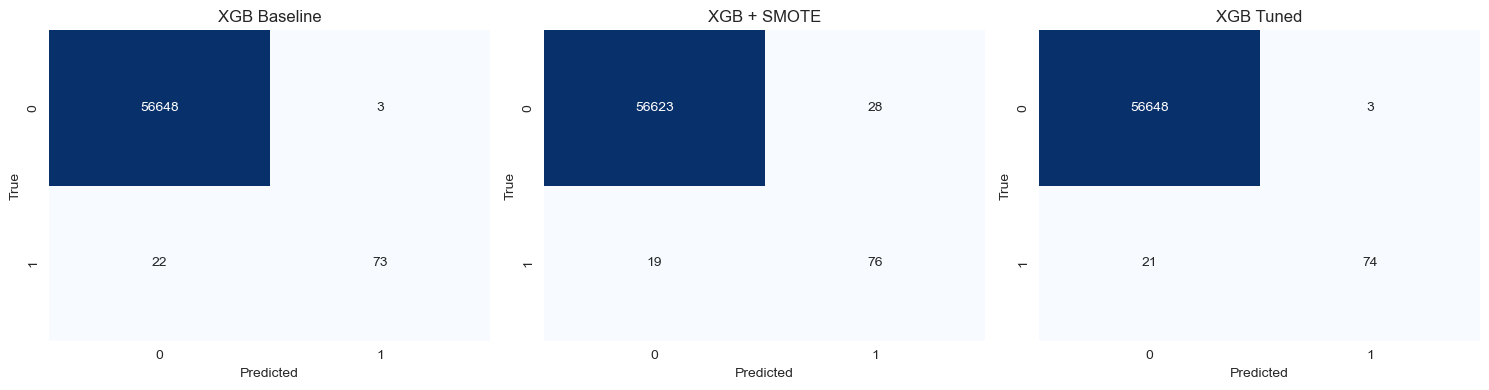

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models_preds = {
    "XGB Baseline": y_pred_baseline,
    "XGB + SMOTE": y_pred_smote,
    "XGB Tuned": y_pred_tuned,
}

for ax, (name, y_pred) in zip(axes, models_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

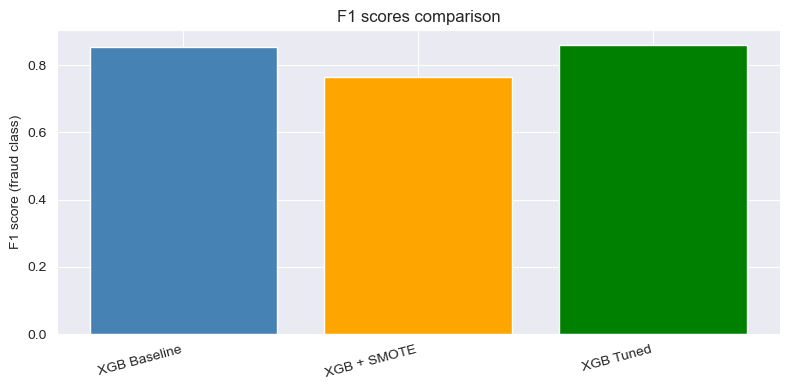

In [33]:
plt.figure(figsize=(8, 4))
plt.bar(results_df["model"], results_df["f1"], color=["steelblue", "orange", "green"])
plt.ylabel("F1 score (fraud class)")
plt.title("F1 scores comparison")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

## 5. Feature importance

XGBoost also provides feature importances, lets see which features matter most.

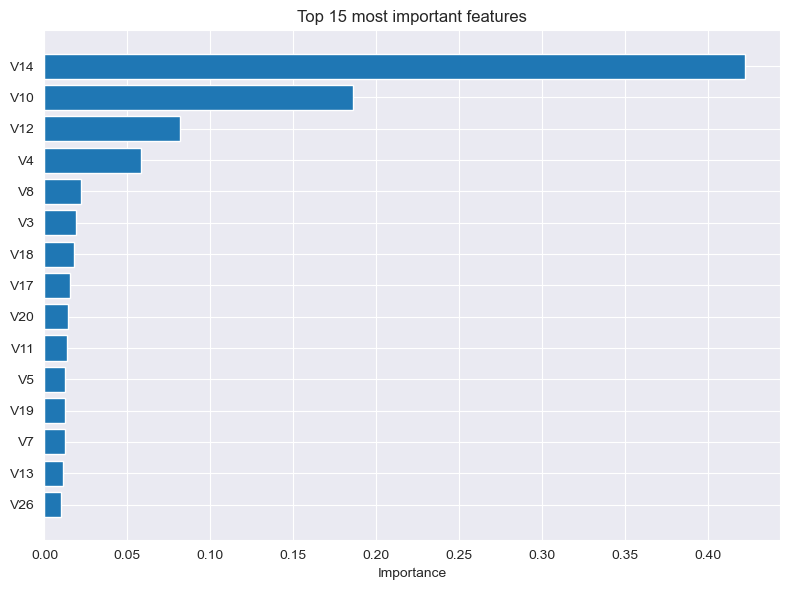

Top 10 features:
feature  importance
    V14    0.422206
    V10    0.185918
    V12    0.081650
     V4    0.057880
     V8    0.022052
     V3    0.019031
    V18    0.017842
    V17    0.015125
    V20    0.014033
    V11    0.013461


In [34]:
xgb_model = best_xgb.named_steps["model"]
importances = xgb_model.feature_importances_

feature_names = numeric_to_scale + other_features

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance_df["feature"][:15][::-1], importance_df["importance"][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 most important features")
plt.tight_layout()
plt.show()

print("Top 10 features:")
print(importance_df.head(10).to_string(index=False))

V14 dominates the feature importance with 63%, while other features contribute much less. Since these are PCA transformed features used to protect privacy, this confirms that the transformation successfully preserved the key fraud patterns while hiding the real customer data.

## 6. Conclusion

We got really good results with XGBoost on our fraud detection problem. We tried three different approaches:

1. **Baseline with scale_pos_weight**: works well out of the box
2. **SMOTE oversampling**: creates synthetic fraud samples to balance the data
3. **Hyperparameter tuning**: fine-tunes the model parameters

The tuned model performs best with an F1 score of 0.86, beating our Random Forest model that got 0.83. It catches 74 out of 95 frauds (77.9% recall) with only 3 false alarms. This means when we tell someone their transaction is fraud, we are right 96% of the time.

What is interesting is that the baseline model already works really well just by using scale_pos_weight. SMOTE also showed good results but with different precision-recall trade-offs. Hyperparameter tuning improved things slightly but the gains are small.

XGBoost gives us the best balance between catching frauds and avoiding false positives. The way it builds trees sequentially, where each new tree learns from the mistakes of previous ones, works really well for our dataset.
